### TP2 : La chasse au papyrus

RÉSUMÉ : Librairies utilisées et compétences :

- Web scraping (beautifulsoup): extraction d'informations

- Nettoyage de datasets (pandas) et plot

- Nettoyage de textes

- Identifier les noms de personnes et de lieux (NER, Hugging Face Ugarit -grec-)

- Etude des fautes de graphie (difflib)

- **Création d'une application présentant les papyrus (streamlit)**





Professeur : Louis JOURDAIN

  Internet regorge de bases de données intéressantes, surtout pour les linguistes et les humanités numériques. En effet, ils mettent souvent en ligne des bases de données spécialisées permettant (gratuitement ou non) d'explorer une collection particulière. Si la base de donnée est hébergée sur le site et naviguable, on ne peut malheureusement pas en faire une exploration quantitative puisque les sites n'offrent pas l'option de télécharger l'ensemble des données. De plus on est pas forcément intéressé par toute la collection ni par toutes les métadonnées disponibles pour chaque document.


Heureusement, python est là pour nous aider !

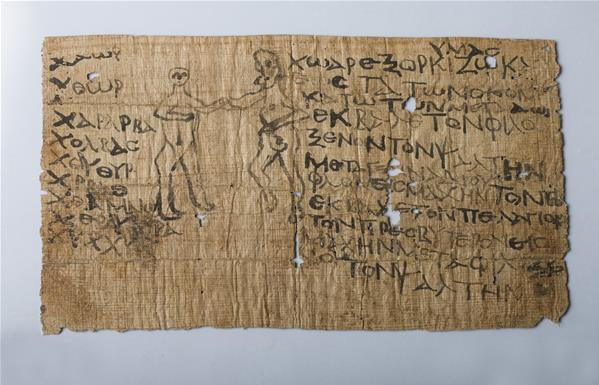

Image issue de https://antiquities.bibalex.org/Collection/Detail.aspx?lang=fr&a=508

L'objectif de ce TP est de collecter, stocker et analyser une collection de papyri grecs. Ce sera l'occasion de voir comment on peut utiliser les librairies de data science actuelles pour observer et analyser un dataset original

**Objectifs :**

1) Résiver les techniques de web scraping pour voir comment collecter un dataset:
* déduire la structure des url à regarder
* télécharger les pages HTML
* regarder la structure de la page et utiliser un parser HTML pour extraire les données

2) stocker les données sous un format csv. Utiliser pandas pour les analyser

3) construire des visualisations intéressantes du dataset

4) gérer le texte grec, son encodage, les outils TAL pour le traiter

5) utiliser streamlit, une librairie intuitive pour créer un front permettant d'explorer la collection de papyri.

**NB : LE TP EST A REALISER DANS DES FICHIERS PY ISOLES ET PAS SUR LE NOTEBOOK **

Le rendu prendra la forme d'une archive contenant 3 fichiers .py ainsi qu'un fichier requirements.txt

# I) Web scraping et collecte de la base de données des papyrus. /6

L'objectif de ce TP est d'analyser une collection de papyri grecs particulière.

Nous nous intéresserons à une partie de la collection préservée sur le site trismegistos.

https://www.trismegistos.org/

Nous ne nous intéresserong qu'à un nombre limité de papyri dont la liste est fournie en annexe (fichier papyrus_metadata.csv)



# 1)Collecte des URL

 A partir de la liste des papyri à étudier, générez la liste des url à crawler. Pour cela parcourez le site pour comprendre la structure des url donnant accès à un papyrus.

In [ ]:
!curl -o papyrus_metadata.csv https://github.com/Dinarque/INALCO_Inalco_M2_langage_de_scripts_2024_eleves/blob/main/TP/papyrus_metadata.csv

In [ ]:
import pandas as pd

url = "https://raw.githubusercontent.com/Dinarque/INALCO_Inalco_M2_langage_de_scripts_2024_eleves/refs/heads/main/TP/papyrus_metadata.csv"
df = pd.read_csv(url)
print(df.head())


        ID                                    Authors / works  \
0  TM58376                                                NaN   
1  TM61011  Homerus,Ilias:2.379-2.382This link will bring ...   
2  TM61596  Menander,Heros: hypothesis and title (epitomiz...   
3  TM61072  Homerus,Ilias:2.494-2.519This link will bring ...   
4  TM19028                                                NaN   

                                           Book form   Content (beta!)  \
0                                                NaN  funerary (human)   
1  codex (10 pages); columns per page: 2; highest...      school text?   
2  codex (17 fol.); columns per page: 1; highest ...               NaN   
3  codex; columns per page: 1; number of lines pe...       school text   
4                                                NaN    Contract: sale   

                                     Culture & genre  \
0                                                NaN   
1  literature, science — poetry, epic + philology...

In [ ]:
df['URL'] = df['ID'].apply(lambda x: f"https://www.trismegistos.org/text/{x}") # ajout colonne URL au df
print(df.head())
list_url = df['URL'].tolist() # len 579
list_url

# 2) Scraping d'une page


Etudiez la structure du HTML des pages présentant un papyrus

https://www.trismegistos.org/text/100

écrire une fonciton scrap_papyrus() prenant en entrée une url et retourne un dictionnaire contenant les informations suivantes sur le papyrus:
* Date
* Provenance
* Language/script
* Material
* Content
* Publications
* Collections
* Archive
* Le texte principal (à formater)
* La liste des noms de personnes
* La liste des noms de lieux
* La liste des irrégularités textuelles

BONUS : Capturez aussi le  numéro du champ TM Geo
servez vous de ces numéros pour capturer le fichier geo json du lieu, qui se trouve sur les pages des lieux comme par exemple https://www.trismegistos.org/place/2982 .



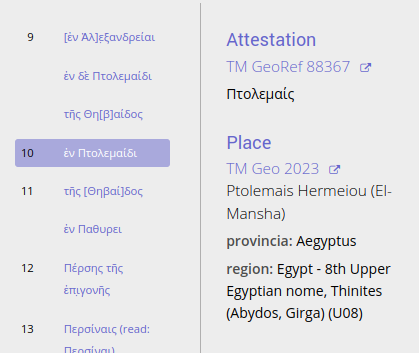

tester ce script sur **une** url au hasard pour vérifier qu'il fonctionne.

(Notes du cours:)

pattern = "<title.*?>.*?</title.*?>" #contenu d'une balise\
match_results = re.search(pattern, html, re.IGNORECASE)\
Utiliser un parser HTML d’une librairie spécialisée (Beautifulsoup, trafilatura, scrapy...)

In [ ]:
!pip install beautifulsoup4

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re

def dico_scraping(url):
  page = urlopen(url)
  html = page.read().decode("utf-8")
  soup = BeautifulSoup(html, "html.parser")

  dico = {}
  # URL
  dico["URL"] = url

  # DATE
  date = soup.find("div",class_="division")
  dico["Date"] = date.get_text(strip=True).split(":",1)[-1].strip()

  # PROVENANCE
  provenance = soup.find(lambda tag:tag.name in ["p","division"] and re.search("Provenance:",tag.text))
  if provenance:
    dico["Provenance"] = provenance.get_text(strip=True).split(":",1)[-1].strip()

  # LANGUAGE/SCRIPT
  langscript = soup.find(lambda tag: tag.name in ["p", "division"] and re.search("Language/script:", tag.text))
  if langscript:
    dico["Language/script"] = langscript.get_text(strip=True).split(":",1)[-1].strip()

  # MATERIAL
  material = soup.find(lambda tag: tag.name in ["p", "division"] and re.search("Material:", tag.text))
  if material:
    dico["Material"] = material.get_text(strip=True).split(":",1)[-1].strip()

  # CONTENT
  content = soup.find(lambda tag: tag.name in ["p", "division"] and re.search("Content", tag.text))
  if content:
    dico["Content"] = content.get_text(strip=True).split(":",1)[-1].strip()

  # AUTHORS / WORKS
  authors_works = soup.find("p", id="authors-works")
  if authors_works:
      authors_works_text = ' '.join(text for text in authors_works.stripped_strings if "Authors / works:" not in text)
      dico["Authors / works"] = authors_works_text

  # PUBLICATIONS
  publications = soup.find("h4", string=lambda text: "Publications" in text if text else False)
  if publications:
    L_publi = []
    for sibling in publications.find_next_siblings("p"):
      publication_text = ' '.join(sibling.stripped_strings)
      L_publi.append(publication_text)
    dico["Publications"] = L_publi

  # COLLECTIONS
  collections = soup.find("h4", string=lambda text: "Collections" in text if text else False)
  if collections:
    L_collect = []
    for sibling in collections.find_next_siblings("p"):
      collections_text = ' '.join(sibling.stripped_strings)
      L_collect.append(collections_text)
    dico["Collections"] = L_collect

  # ARCHIVE
  archive = soup.find("h4", string=lambda text: "Archive" in text if text else False)
  if archive:
    dico["Archive"] = archive.find_next("p").get_text(strip=True) #.split(":",1)[-1].strip()


  # TEXTE
  container = soup.find("div", {"id": "words-full-text"})
  lines = []
  current_line = []
  for element in container.descendants:
      if element.name == "a" and element.get("target") == "_blank":
          # Extract only the text before the first <span>
          text = element.decode_contents().split("<span", 1)[0].strip()
          current_line.append(text)
      elif element.name == "br":
          # If a <br> is encountered, add the current line and start a new line
          if current_line:
              lines.append(" ".join(current_line))
              current_line = []
  # Add the last line if it exists
  if current_line:
      lines.append(" ".join(current_line))
  output_text = "\n".join(lines)
  dico['Texte'] = output_text


  # PEOPLE
  people = soup.find('div', {'id': 'people'})
  items = people.find_all('li')
  seen = set()
  result = []
  # Extraire les noms sans doublons en conservant l'ordre
  for item in items:
      # Vérifier si l'élément a la classe 'item-large' pour extraire le nom
      name_tag = item.find('li', class_='item-large')
      if name_tag:
          name = name_tag.get_text(strip=True)
          if name not in seen:  # Si le nom n'a pas encore été ajouté
              seen.add(name)
              result.append(name)
  dico['People'] = result


  # LIEUX
  lieux = soup.find('div', {'id': 'places'})
  items = lieux.find_all('li')
  seen = set()
  L_lieux = []
  for item in items:
      # Vérifier si l'élément a la classe 'item-large' pour extraire le lieu
      name_tag = item.find('li', class_='item-large')
      if name_tag:
          lieu = name_tag.get_text(strip=True)
          if lieu not in seen:  # Si le nom n'a pas encore été ajouté
              seen.add(lieu)
              L_lieux.append(lieu)
  dico['Lieux'] = L_lieux


  # IRREGULARITES TEXTUELLES
  lieux = soup.find('div', {'id': 'texirr'})
  items = lieux.find_all('li')
  seen = set()
  L_irr = []
  for item in items:
      # Vérifier si l'élément a la classe 'item-large' pour extraire le lieu
      name_tag = item.find('li', class_='item-large')
      if name_tag:
          irr = name_tag.get_text(strip=True)
          if irr not in seen:  # Si le nom n'a pas encore été ajouté
              seen.add(irr)
              L_irr.append(irr)
  dico['Irrégularités textuelles'] = L_irr

  return dico

dico_scraping('https://www.trismegistos.org/text/100')

{'URL': 'https://www.trismegistos.org/text/100',
 'Date': 'BC 114 Apr 7',
 'Provenance': 'Pathyris (Gebelein)- Egypt (4th Upper Egyptian nomeThe Egyptian nome ca. 3rd cent. BC-AegyptusThe Roman provincia ca. 2nd cent. AD) [found & written]',
 'Language/script': 'Greek',
 'Material': 'papyrus',
 'Content': 'Contract: cession',
 'Publications': ['P. Strasb. Gr. 2 83  ( Preisigke, Friedrich - 1920) [default]',
  'Other bibliography: BL 2.2, 1933'],
 'Collections': ['→ Strasbourg, Bibliothèque Nationale P. gr. 65'],
 'Archive': 'Peteharsemtheus son of Panebchounis',
 'Texte': '[βασιλ]ευόντων\nβ̣[α]σιλίσσης\nκ[αὶ]\nβασιλέως θεῶν\nἔτους γ , [ἐφʼ]\nἱερείως* βασι[λ]έως\nθεοῦ\nκαὶ θεῶν καὶ θεῶν\nκαὶ θεῶ[ν]\n[κα]ὶ\nθεῶν καὶ θεῶν\nκαὶ θεο[ῦ]\n[καὶ]\nθεοῦ καὶ θεοῦ\nκ̣αὶ\nθεοῦ καὶ θε[ῶν]\n, ἱεροῦ πώλου\nμεγάλης μητρὸς θεῶ[ν]\n[,]\n[ἀ]θλοφόρου\n,\n[καν]η̣φόρου\n, ἱερείας τῶν ὄντων\n[ἐν]\n[Ἀλ]ε̣ξανδρείαι , ἐν δὲ Πτολεμαίδι τῆς Θη[β]αίδος ἐφʼ ἱερείων* καὶ\n[ἱερισσ]ῶν\nκαὶ κανη̣φόρου\nτῶν ὄντων καὶ οὐσ

# 3) Scraping total

dans un fichier scraping.py écrire un programme qui:
* lit le fichier de papyri à scanner et en déduit la liste d'url à scraper
* scrape chaque url (cf 2) )
* stocke toutes ces informations dans un fichier .csv nommé papyri.csv

**N EXECUTEZ PAS CE CODE CAR IL METTRAIT 20mn A TOURNER ET QUE LE SCRAPING N EST PAS UNE ACTIVITE QUE LES SITES APPRECIENT. JE FOURNIRAI LE CSV POUR PASSER A LA PARTIE II**

à la rigueur, testez votre code sur un ensemble de 3 pages web et pas les 600...


In [ ]:
# A NE PAS EXECUTER

import pandas as pd

url = "https://raw.githubusercontent.com/Dinarque/INALCO_Inalco_M2_langage_de_scripts_2024_eleves/refs/heads/main/TP/papyrus_metadata.csv"
df = pd.read_csv(url)

df['URL'] = df['ID'].apply(lambda x: f"https://www.trismegistos.org/text/{x}") # ajout colonne URL au df
list_url = df['URL'].tolist() # len 579

data = [] # liste qu'on va transformer en csv

for url in list_url: # à ne pas exécuter
  dico = dico_scraping(url)
  data.append(dico)

df_data = pd.DataFrame(data)

df_data.to_csv("papyri.csv", index=False, encoding='utf-8')

# II) Analyse du dataset /10



Dans cette partie, nous allons utiliser les librairies de datascience pour visualiser, analyser et enrichir le corpus que nous avons scrapé

Pour ne pas pénaliser un scraping imparfait et que je puisse vérifier plus facilement les résultats, vous allez tous télécharger le fichier "papyrus_corpus.csv".

Vous pouvez traitez cette partie du TP soit dans le notebook, soit dans un fichier nommé corpus_analysis.py qui devra s'exécuter correctement de A à Z, affichez les réponses avec un message explicite (print correctement f formatté) et les graphiques demandés (plt.show()) après chaque graphe)

# 4) Chargement et nettoyage du dataset

Il faut d'abord charger ce corpus et le nettoyer un peu:
* Charger le fichier csv dans un DataFrame
* Observer le dataset. Que dire des 4 premières lignes ?  Que faire ? Faites-le.
* Combien de textes n'ont pas été capturés pendant le scraping ? Comment le voit-on ? Enlevez-les
* Combien la collection compte-t elle de papyrus après nettoyage ?
* Trier la collection selon l'ID (ordre croissant)

In [ ]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/Dinarque/INALCO_Inalco_M2_langage_de_scripts_2024_eleves/refs/heads/main/TP/papyrus_corpus.csv',sep=',')
print(df.head())

         ID                                    Authors / works  \
0  TM 58376                                                NaN   
1  TM 61011  Homerus,Ilias:2.379-2.382This link will bring ...   
2  TM 61596  Menander,Heros: hypothesis and title (epitomiz...   
3  TM 61072  Homerus,Ilias:2.494-2.519This link will bring ...   
4  TM 19028                                                NaN   

                                           Book form   Content (beta!)  \
0                                                NaN  funerary (human)   
1  codex (10 pages); columns per page: 2; highest...      school text?   
2  codex (17 fol.); columns per page: 1; highest ...               NaN   
3  codex; columns per page: 1; number of lines pe...       school text   
4                                                NaN    Contract: sale   

                                     Culture & genre  \
0                                                NaN   
1  literature, science — poetry, epic + philol

In [ ]:
# que dire des 4 1ères lignes
# On a beaucoup de valeurs NaN dans la colonne Full Text. On pourrait enlever ces lignes.
# On a beaucoup de NaN dans les 4 colonnes Note, Reuse note, Reuse type, Ro. Donc on pourrait supprimer ces colonnes.
df = df.drop(columns=['Note', 'Reuse note', 'Reuse type', 'Ro'])

In [ ]:
# Nb de textes NaN # enlever

print(f"Nombre de textes Nan: {df['Full Text'].isna().sum()}")
df_cleaned = df.dropna(subset=['Full Text']).reset_index(drop=True)
df_cleaned.head()
print(f"Taille du dataframe nettoyé: {len(df_cleaned)}, contrairement à avant: {len(df)}")

# 459 papyri maintenant après nettoyage

Nombre de textes Nan: 120
Taille du dataframe nettoyé: 459, contrairement à avant: 579


In [ ]:
# trier ID ordre croissant

# Extraire les parties numériques des IDs et les utiliser pour trier
df_cleaned['ID_numeric'] = df_cleaned['ID'].str.extract(r'(\d+)', expand=False).astype(int)

df_sorted = df_cleaned.sort_values(by='ID_numeric').drop(columns=['ID_numeric']).reset_index(drop=True)

print(df_sorted.head())
len(df_sorted)

In [ ]:
df = df_sorted

# 5) Etude de corpus : genre, lieu et date


* Quelles sont les différents genre de texte que l'on a collecté ? La nomenclature de la colonne "Content (beta!) est un peu trop précise. Basez-vous sur le premier mot et créez un graphique.
* Affichez cela sous la forme d'un pie chart
* combien de papyri ont-ils été réutilisés ?

* D'où viennent les papyri ?  De même ne retenez que le nom de la ville. Faites un diagramme en barre cette fois.
* Qu'en concluez-vous ?

*Identifier la date d'écriture. Observez la catégorie des dates et nettoyez le texte pour regrouper ensemble les catégories pertinente
* Formattez les dates sous le format d'une date simple AD xxx
ou d'un intervalle AD xxx - xxx
* Utilisez ensuite ces valeurs discrètes ou intervalles pour construire un diagramme représentant la densité de papyri sur chaque année du dataset.
NB quand il y a plusieurs dates mentionnées dans la colonne on ne prendra en compte que la première
NB : il faudra transformer les bornes en intervalles continus.

NB Les graphes devraient ressembler à ça :



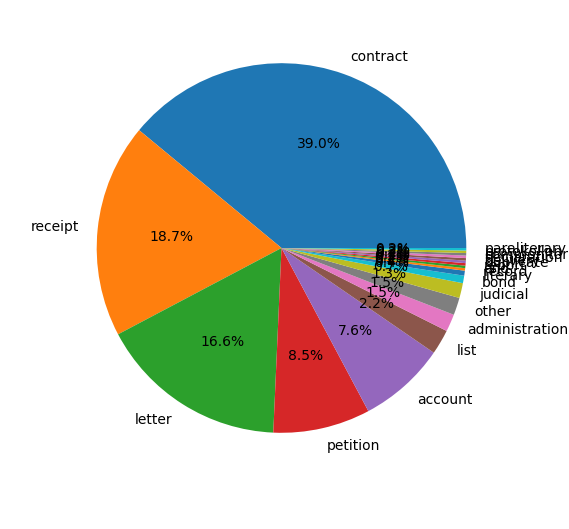

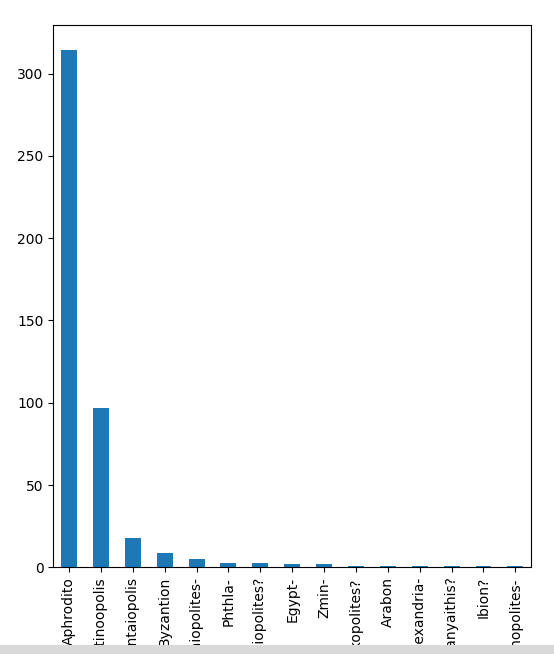

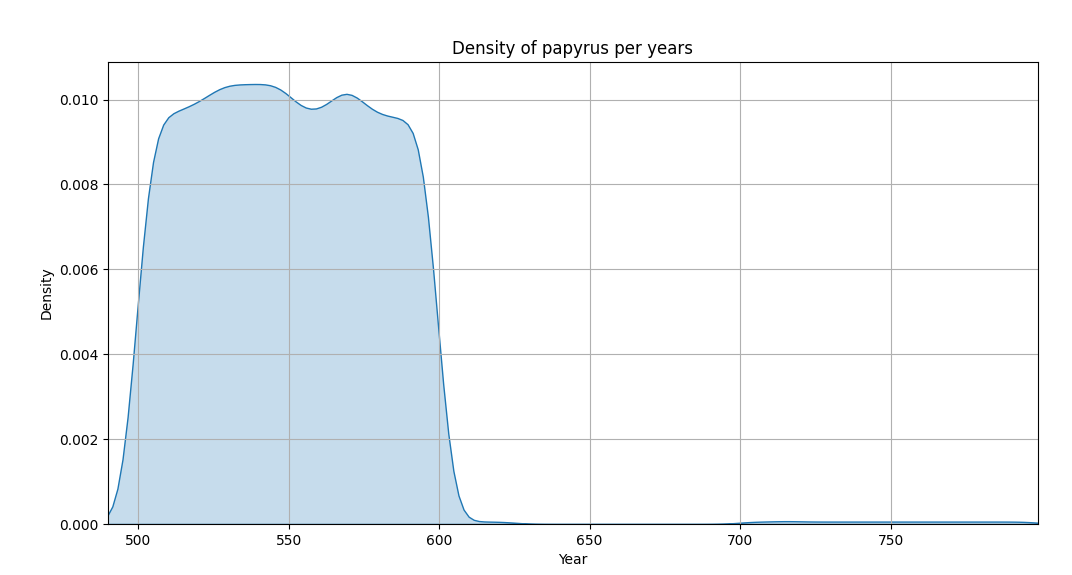

In [ ]:
df['Content_first_word'] = df['Content (beta!)'].str.split().str[0]\
                           .str.replace(r'[^\w\s]', '', regex=True)\
                           .str.lower()
df['Content_first_word'].value_counts()

,count
Content_first_word,
contract,179
receipt,86
lettersee,42
account,35
letter,34
petition,28
petitionsee,11
list,10
administration,7


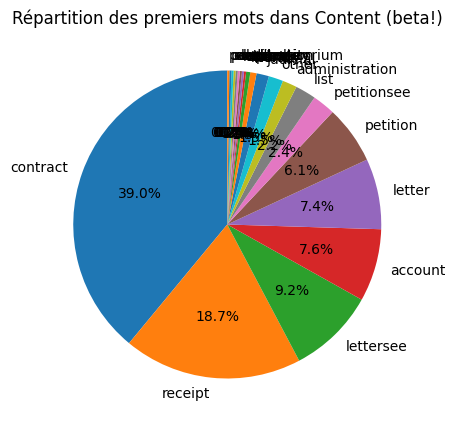

In [ ]:
import matplotlib.pyplot as plt

content_valuecounts = df['Content_first_word'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(content_valuecounts, labels=content_valuecounts.index, autopct='%1.1f%%', startangle=90)
plt.title('Répartition des premiers mots dans Content (beta!)')
plt.show()

# on pourrait affiner le filtrage des premiers mots pour par exemple regrouper "letter" et "lettersee" dans "letter", pareil pour "petitionsee" et "petition", et aussi filtrer des mots qui ont du sens.

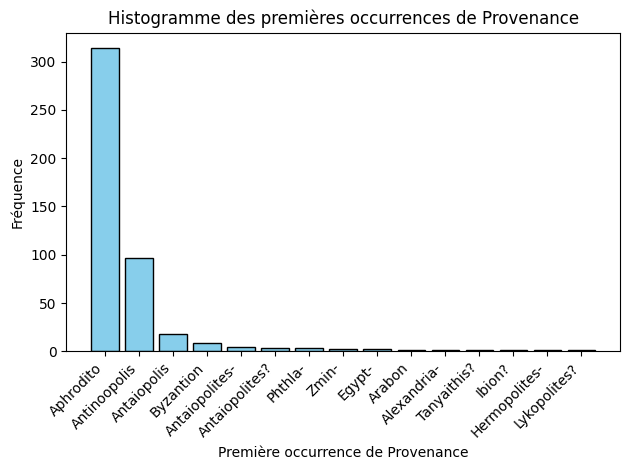

In [ ]:
# Provenance des papyri

df['Provenance_first_word'] = df['Provenance'].str.split().str[0]

provenance_valuecounts = df['Provenance_first_word'].value_counts()

plt.bar(provenance_valuecounts.index, provenance_valuecounts.values, color='skyblue', edgecolor='black')
plt.title('Histogramme des premières occurrences de Provenance')
plt.xlabel('Première occurrence de Provenance')
plt.ylabel('Fréquence')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Presque tous les papyri viennent de Aphrodito (environ 300), et environ 100 viennent de Antinoopolis.

In [ ]:
# Formattez les dates sous le format d'une date simple AD xxx ou d'un intervalle AD xxx - xxx
import re
def reformat_date(date):
    match = re.search(r"AD (\d+)(?: - (\d+))?", str(date))
    if match:
        # Si on trouve une plage (avec un tiret)
        if match.group(2):
            return f"AD {match.group(1)} - {match.group(2)}"
        # Si seulement une seule date est présente
        return f"AD {match.group(1)}"
    return "AD -1"  # Si aucun format "AD xxx" trouvé

df['Reformatted_Date'] = df['Date'].apply(reformat_date)

df[['Reformatted_Date','Date']]

,Reformatted_Date,Date
0,AD 565,aboutAD 565?
1,AD 566,AD 566 Feb 22?
2,AD 531,AD 531 May 22?
3,AD 551,year 26 of Iustinianus: AD 551 Aug 30 - 552 Au...
4,AD 569,year 5 of Iustinus II: AD 569 Aug 29 - 570 Aug 28
...,...,...
454,AD 500 - 599,6th century AD: AD 500 - 599
455,AD 602,AD 602 Aug 13 - Nov 27
456,AD 567 - 573,AD 567 - 573
457,AD 500 - 599,6th century AD: AD 500 - 599


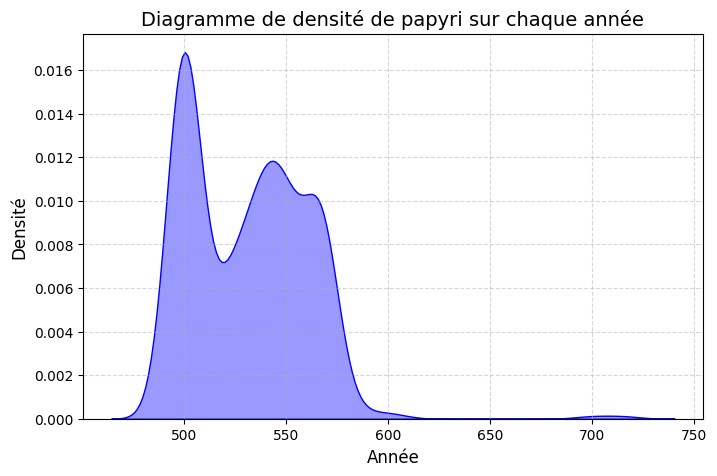

In [ ]:
# Diagramme représentant la densité de papyri sur chaque année du dataset.
# NB quand il y a plusieurs dates mentionnées dans la colonne on ne prendra en compte que la première
# NB : il faudra transformer les bornes en intervalles continus.

import seaborn as sns

df['First_Date'] = df['Reformatted_Date'].apply(lambda x: int(re.search(r"AD (\d+)", x).group(1)))

plt.figure(figsize=(8, 5))
sns.kdeplot(df['First_Date'], fill=True, color="blue", alpha=0.4)
plt.title("Diagramme de densité de papyri sur chaque année", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Densité", fontsize=12)
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.show()

# 6) Nettoyage du texte grec

* écrivez une première fonction de nettoyage du texte qui retire les chiffres arabes, les lignes perdues | gap | ainsi que les caractères spéciaux "†" et "⳨". Appliquez là au texte.
*  Voici la signification de certains codes en papyrologie :
 - Les petits points en dessous de certaines lettres indiquent que la lettre est défformée ou difficilement lisible
 - Les zones entre crochets droits ou parenthèses indiquent que le texte est reconstitué par un auteur, et était illisible / détruit.
 Ecrivez une fonction qui prend en entrée un texte de papyrus nettoyé et renvoie la proportion de lettres incertaines dans le texte. Stockez pour chaque texte cette valeur dans la colonne "Uncertain Portion"
 Combien y a-t de papyrus dont plus du tiers du texte est incertain ?

* Ecrivez une fonction qui enlève les parenthèses et les crochets mais converve leur contenu. Utilisez là sur le texte


In [ ]:
#  1. Nettoyage du texte qui retire les chiffres arabes, les lignes perdues | gap | ainsi que les caractères spéciaux "†" et "⳨"
# df["Full Text Cleaned"] = df["Full Text"].str.replace(r'\d','',regex=True).str.replace(r'†⳨','',regex=True)
import re
def clean_text(texte):
  texte = re.sub(r'\d+|^.*\| gap \|.*$|[†⳨]|\n+', lambda match: '' if match.group(0).startswith('| gap |') else '\n', texte, flags=re.MULTILINE).strip()
  return texte

df["Full Text Cleaned"] = df["Full Text"].apply(clean_text)
df["Full Text Cleaned"]

In [ ]:
# 2. Ecrivez une fonction qui prend en entrée un texte de papyrus nettoyé et renvoie la proportion de lettres incertaines dans le texte.
# Stockez pour chaque texte cette valeur dans la colonne "Uncertain Portion". Combien y a-t de papyrus dont plus du tiers du texte est incertain ?

def uncertainty(text):
  # Trouver toutes les lettres incertaines (sous-dotées ou entre crochets/parenthèses)
  uncertain_letters = re.findall(r"[a-zA-Zά-ώΆ-Ώ]̣|[\[\(].*?[\]\)]", text)
  # Trouver toutes les lettres alphabétiques (valables)
  total_letters = re.findall(r"[a-zA-Zά-ώΆ-Ώ]", text)
  # Calculer la proportion d'incertitude
  if total_letters:  # éviter la division par zéro
    return len(uncertain_letters) / len(total_letters)
  return 0

df["Uncertain Portion"] = df["Full Text Cleaned"].apply(uncertainty)

# Compter les textes avec plus du tiers du texte incertain
num_uncertain_texts = (df["Uncertain Portion"] > 1/3).sum()

print(df["Uncertain Portion"])
print(f"Nombre de papyrus avec plus du tiers du texte incertain : {num_uncertain_texts}")

0      0.139647
1      0.079787
2      0.220524
3      0.167702
4      0.195219
         ...   
454    0.072000
455    0.160221
456    0.162651
457    0.209524
458    0.264901
Name: Uncertain Portion, Length: 459, dtype: float64
Nombre de papyrus avec plus du tiers du texte incertain : 25


In [ ]:
# 3. Ecrivez une fonction qui enlève les parenthèses et les crochets mais converve leur contenu. Utilisez là sur le texte.

df['Full Text Cleaned 2'] = df['Full Text Cleaned'].str.replace(r'[\[\]\(\)]', '', regex=True)

df[['Full Text Cleaned','Full Text Cleaned 2']]

,Full Text Cleaned,Full Text Cleaned 2
0,[--------------------] [---] \n τῆς τάξεως ...,-------------------- --- \n τῆς τάξεως τῆς ...
1,Κωνσταντῖνος Καλλινίκου σιγγ(ουλάριος) τῷ ...,Κωνσταντῖνος Καλλινίκου σιγγουλάριος τῷ ἀδ...
2,[---] |slanting-stroke| \n [μετὰ] [τὴν] [ὑπ...,--- |slanting-stroke| \n μετὰ τὴν ὑπατείαν ...
3,δέδωκεν Ἀπολλὼς Διοσκώρου* δι(ὰ) τῶν κληρ...,δέδωκεν Ἀπολλὼς Διοσκώρου* διὰ τῶν κληρον...
4,[---] [δεσπότου] [ἡμῶν] [Φ]λ̣[αυ]ί̣[ο]υ Ἰ[ο]...,--- δεσπότου ἡμῶν Φλ̣αυί̣ου Ἰουστίνου τοῦ ...
...,...,...
454,|gap=\n_lines| \n \n Παπνούθης φρουρὸς δ(ιὰ...,|gap=\n_lines| \n \n Παπνούθης φρουρὸς διὰ ...
455,[\n] [ἐν] [ὀνόματι] [τοῦ] κυρίου καὶ δεσ...,\n ἐν ὀνόματι τοῦ κυρίου καὶ δεσπότου ἡ...
456,[--------------------] [---] [ε]ἰ̣ς̣ τ̣α̣ύ̣...,-------------------- --- εἰ̣ς̣ τ̣α̣ύ̣την \n...
457,[--------------------] [---][.][---] \n [---]...,-------------------- ---.--- \n ---.τῆς τοῦ ...


In [ ]:
df = df.drop('Full Text Cleaned', axis=1).rename(columns={"Full Text Cleaned 2": "Full Text Cleaned"})

# 7) Identifier les noms de personnes et de lieux

* Observez le contenu des cellules de la case "people-list". Que remarquez-vous ? Réglez le(s) problème(s) de manière à ne retenir que les noms

* Téléchargez le modèle de NER suivant sur Hugging Face https://huggingface.co/UGARIT/grc-ner-bert
* Utilisez le pour stocker les entités repérées dans les colonnes "People Ugarit" "Places Ugarit" et "Other Ugarit"
Commentez les résultat

* Calculez le F1 score du système de NER sur notre corpus : de façon sévère (la catégorie de l'entité importe) et de façon tolérante (la catégorie de l'entité n'importe pas)


In [ ]:
df['People List']
# On voit qu'il y a des numéros avant les noms, les noms sont entre guillemets et crochets, et il y a des erreurs d'extraction de noms (par exemple "Subscrite...")

,People List
0,"[' 1Διοσκόρου', 'Subscribe to export the table']"
1,"[' 1Διόσκορος', 'Ψιμανωβετ', 'Subscribe to exp..."
2,"[' 1Ἁραοῦτος', ' 2Φοιβάμμωνι', 'Τριαδέλφου', '..."
3,"[' 3Ἀμμωνιανὸς', 'Διονυσοδώρου', ' 4Πάιος', 'Θ..."
4,"[' 5Πουῶνς', ' 7Φιλόξενον', 'Subscribe to expo..."
...,...
454,"[' 5Πανυμφίου', ' 7Ἰωάννου', 'Κορνηλίου', 'Αὐρ..."
455,"[' 5...', ' 6Σαβινιανω', ' 7Πέτρου', ' 8Θεοδωρ..."
456,"[' 6Αὐρήλιος ...ιας', 'Ἀπλῶτος', 'Κύρας', 'Sub..."
457,"[' 2Σενούθου', ' 5Σευῆρος', ' 7Σευῆρος', ' 8Σε..."


In [ ]:
# on enlève les chiffres
df['People List'] = df['People List'].str.replace(r'\d+', '', regex=True)

In [ ]:
!pip install langdetect

In [ ]:
# On supprime maintenant les éléments de la liste qui sont des mots anglais
import ast
from langdetect import detect, LangDetectException

def clean_people(people):
    ppl_list = ast.literal_eval(people)  # convertit la chaîne en liste Python
    cleaned_list = []

    for ppl in ppl_list:
        try:
            lang = detect(ppl)
            if lang != 'en': # Garder si la langue détectée n'est pas l'anglais
                cleaned_list.append(ppl)
        except LangDetectException:
            # Si c'est un problème de détection mais que le texte semble être un nom, on le garde
            if len(ppl.strip()) > 4:  # Vérifie que ce n'est pas vide ou trop court
                cleaned_list.append(ppl)
            else:
                print(f"Supprimé (pas de features valides) : {ppl}")
    return cleaned_list

df['People List Cleaned'] = df['People List'].apply(clean_people)
df['People List Cleaned']

In [ ]:
#df = df.drop('People List Cleaned', axis=1)

In [ ]:
# Enfin, on supprime les crochets et les guillemets
df['People List Cleaned'] = df['People List Cleaned'].astype(str)
df['People List Cleaned'] = df['People List Cleaned'].str.replace(r'\[|\]', '', regex=True)
df['People List Cleaned'] = df['People List Cleaned'].str.replace("'", "", regex=False)

In [ ]:
df[['People List','People List Cleaned']]

,People List,People List Cleaned
0,"[' Διοσκόρου', 'Subscribe to export the table']",Διοσκόρου
1,"[' Διόσκορος', 'Ψιμανωβετ', 'Subscribe to expo...","Διόσκορος, Ψιμανωβετ"
2,"[' Ἁραοῦτος', ' Φοιβάμμωνι', 'Τριαδέλφου', ' Ἁ...","Ἁραοῦτος, Φοιβάμμωνι, Τριαδέλφου, Ἁραοῦτος,..."
3,"[' Ἀμμωνιανὸς', 'Διονυσοδώρου', ' Πάιος', 'Θέω...","Ἀμμωνιανὸς, Διονυσοδώρου, Πάιος, Θέωνος, Ἱέ..."
4,"[' Πουῶνς', ' Φιλόξενον', 'Subscribe to export...","Πουῶνς, Φιλόξενον"
...,...,...
454,"[' Πανυμφίου', ' Ἰωάννου', 'Κορνηλίου', 'Αὐρηλ...","Πανυμφίου, Ἰωάννου, Κορνηλίου, Αὐρηλίᾳ Σοφίᾳ..."
455,"[' ...', ' Σαβινιανω', ' Πέτρου', ' Θεοδωρακίο...","Σαβινιανω, Πέτρου, Θεοδωρακίου, Κολλουθος,..."
456,"[' Αὐρήλιος ...ιας', 'Ἀπλῶτος', 'Κύρας', 'Subs...","Αὐρήλιος ...ιας, Ἀπλῶτος, Κύρας"
457,"[' Σενούθου', ' Σευῆρος', ' Σευῆρος', ' Σευῆρο...","Σενούθου, Σευῆρος, Σευῆρος, Σευῆρος, Σευῆ..."


In [ ]:
# Utilisez NER Ugarit Hugging  pour stocker les entités repérées dans les colonnes "People Ugarit" "Places Ugarit" et "Other Ugarit" Commentez les résultat

from transformers import pipeline

# Initialize the NER pipeline for Ancient Greek
ner = pipeline('ner', model="UGARIT/grc-ner-bert", aggregation_strategy='first')

In [ ]:
def apply_ner(text):
  ner_results = ner(text)
  # Extraire les entités en fonction de leur 'entity_group'
  people = [result['word'] for result in ner_results if result['entity_group'] == 'PER']
  places = [result['word'] for result in ner_results if result['entity_group'] == 'LOC']
  others = [result['word'] for result in ner_results if result['entity_group'] not in ['PER', 'LOC']]

  # Retourner un tuple avec les entités
  return ', '.join(people) if people else None, ', '.join(places) if places else None, ', '.join(others) if others else None

df[['People Ugarit', 'Places Ugarit', 'Other Ugarit']] = df['People List Cleaned'].apply(lambda x: pd.Series(apply_ner(x)))

print(df[['People List Cleaned', 'People Ugarit', 'Places Ugarit', 'Other Ugarit']])

                                   People List Cleaned  \
0                 Νέπωτος, Ἀφθονίου,  Νέπως,  Ἀφθονίου   
1     Κωνσταντῖνος, Καλλινίκου, Διοσκόρῳ, Ἀπολλῶτος...   
2                 Αὐρηλίῳ ...,  Αὐρήλιοι ..., Ἰωσηφίου   
3     Ἀπολλὼς, Διοσκώρου,  Τιμοθέου,  Ἰουλιανὸς,  Π...   
4     Ἀβρααμίου,  Μηναδίας,  Αὐρηλίων Γενναδίου,  Ἀ...   
..                                                 ...   
454   Παπνούθης, Φοιβάμμωνος, Λεωντίου, Φοιβάμμωνι,...   
455                    Αὐρήλιος ...ιας, Ἀπλῶτος, Κύρας   
456                                                      
457                    Ἀντίνοος, Διόσκορος,  Πανεσνευς   
458                                                      

                                         People Ugarit Places Ugarit  \
0                                                 None          None   
1    κωνσταντινος, διοσκορω, σενουθου, κωνσταντινος...          None   
2                                    αυρηλιω, ιωσηφιου          None   
3     απολλως, 

# 8) Etude des fautes de graphie

La colonne Irrtex stocke la liste des erreurs d'orthographe ou orthographes non standard utilisées par les scribes. On va essayer de se servir de ces commentaires des papyrologues pour faire une description des particularités du grec d'époque hellénistique en Egypte


*  Les indices des Text Irregularities vous donnent un mot dans son écriture du papyrus puis dans son écriture correcte. C'est seulement le segment qui change qui nous intéresse ici. Utilisez la librairie difflib pour lire les string du type XXAX : read XXBX pour extraire le changement (A, B)
* Créez un nouveau DataFrame nommé "sound_change_df"  qui aura pour colonne "old" (forme correcte en grec classique) "new" (forme trouvée dans le papyrus) et remplissez le en lisant les erreurs relevées dans la colonne Irrtex
Normalisez le texte en amont et enlevez les signes diacritiques
* Quels sont les  10 changements les plus fréquents ?
* Quels graphèmes du grecs classiques ont été modifiés plus de 30 fois dans le dataset ?
* Créez un graphique unique qui représente pour chacun de ces 8 graphèmes la nouvelle forme qu'il va prendre sous la forme d'un pie chart (utilisez les subplots de matplotlib)

BONUS  :
Représentez le graphe de conversion de sons (chaque noeud représente un son, le poids d'une arrete le nombre de changements constatés dans le corpus) (utilisez par exemple networkx ou pyvis)

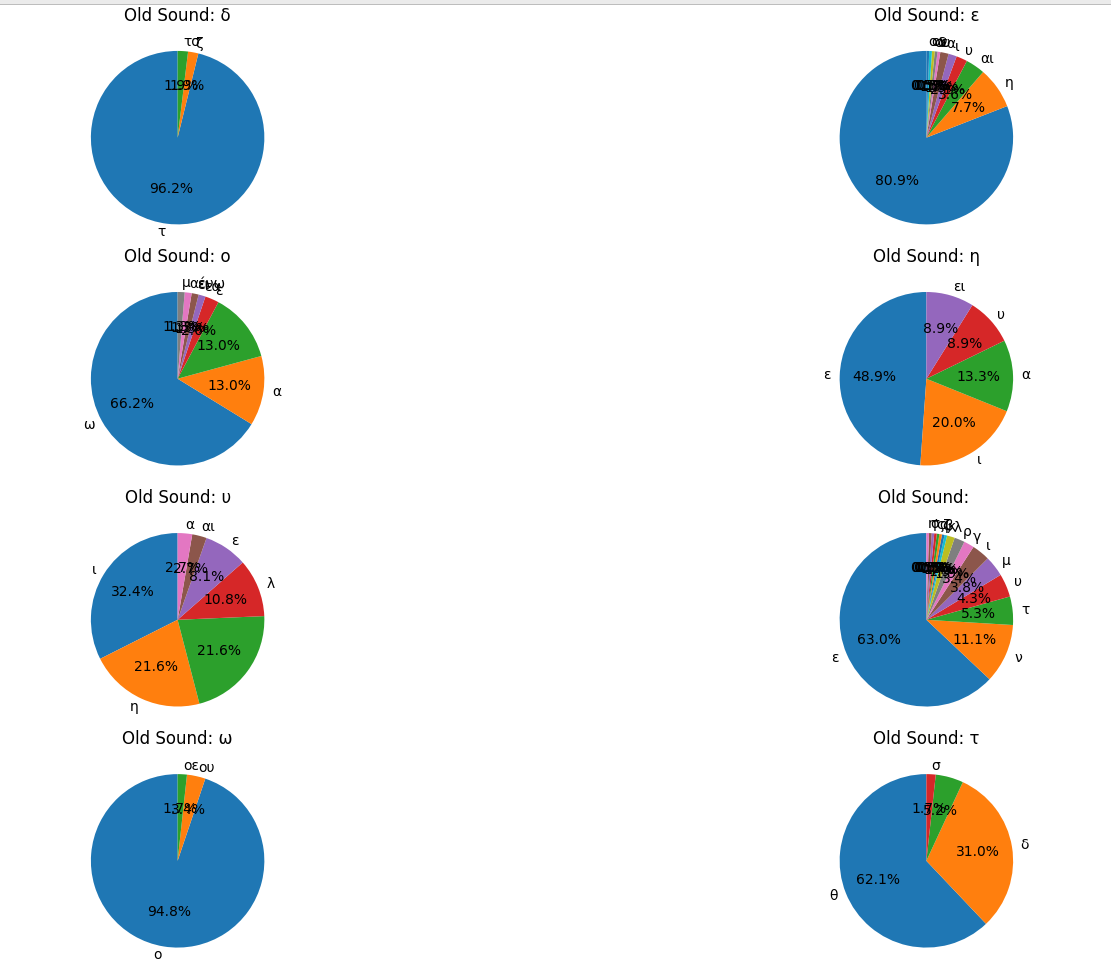

In [ ]:
import difflib

def extract_changes(text):
    irreg_list = ast.literal_eval(text) # convertit en liste python
    changes = []
    for irreg in irreg_list:
        parts = irreg.split(": read ")  # séparer l'orthographe incorrecte et correcte
        if len(parts) == 2:
            wrong, correct = parts
            # Enlever les caractères non alphanumériques pour obtenir les segments de mot
            changes.append((wrong.strip(), correct.strip()))
    return changes


# Appliquer la fonction pour extraire les changements et les stocker dans une nouvelle colonne
df['Irregularities Pairs'] = df['Text Irregularities'].apply(extract_changes)

# Afficher le dataframe avec les couples extraits
print(df[['Text Irregularities', 'Irregularities Pairs']])

                                   Text Irregularities  \
0                    ['ἐξπελλευτοὶ: read ἐξπελλευταὶ']   
1                                                   []   
2                  ['προφερομενην: read προφερομένης']   
3    ['Διοσκώρου: read Διοσκόρου', 'Ἀφροτίτης: read...   
4                           ['ἡμίσιαν: read ἡμίσειαν']   
..                                                 ...   
454  ['ἀρβας: read ἀρ<τά>βας', 'ϊνδικτιονος: read ἰ...   
455                                                 []   
456                                                 []   
457                                                 []   
458                                                 []   

                                  Irregularities Pairs  
0                         [(ἐξπελλευτοὶ, ἐξπελλευταὶ)]  
1                                                   []  
2                       [(προφερομενην, προφερομένης)]  
3     [(Διοσκώρου, Διοσκόρου), (Ἀφροτίτης, Ἀφροδίτης)]  
4                 

In [ ]:
# Créez un nouveau DataFrame nommé "sound_change_df" qui aura pour colonne "old" (forme correcte en grec classique)
# "new" (forme trouvée dans le papyrus) et remplissez le en lisant les erreurs relevées dans la colonne Irrtex
# Normalisez le texte en amont et enlevez les signes diacritiques

sound_change_data = []

for index, row in df.iterrows():
    for old, new in row['Irregularities Pairs']:
        sound_change_data.append((old, new))

# Créer un DataFrame
sound_change_df = pd.DataFrame(sound_change_data, columns=['old', 'new'])

print(sound_change_df)

               old           new
0      ἐξπελλευτοὶ   ἐξπελλευταὶ
1     προφερομενην  προφερομένης
2        Διοσκώρου     Διοσκόρου
3        Ἀφροτίτης     Ἀφροδίτης
4          ἡμίσιαν      ἡμίσειαν
...            ...           ...
1687     τριάκωντα     τριάκοντα
1688   ϊνδικτιονος   ἰνδικτιώνος
1689      ἀξιοθεὶς      ἀξιωθεὶς
1690      ἐντάκιον      ἐντάγιον
1691           μοὶ            μὴ

[1692 rows x 2 columns]


In [ ]:
# Quels sont les 10 changements les plus fréquents ?

# Compter les occurrences de chaque couple (old, new)
change_counts = sound_change_df.groupby(['old', 'new']).size().reset_index(name='count')

# Trier par fréquence décroissante
top_changes = change_counts.sort_values(by='count', ascending=False).head(10)

# Afficher les 10 changements les plus fréquents
print(top_changes)



                 old              new  count
299             καθʼ             κατʼ     35
1007         ἐννάτης           ἐνάτης     15
741   τρισκαιδεκάτης  τρεισκαιδεκάτης     10
816            ἀγγῖα           ἀγγεῖα     10
452         νόμτισμα          νόμισμα     10
359             κἀγὼ          καὶ ἐγὼ      9
724              τον              τῶν      8
749               τω               τὸ      8
172               δε               τε      8
500      παραμυθείας       παραμυθίας      8


In [ ]:
# Quels graphèmes du grecs classiques ont été modifiés plus de 30 fois dans le dataset ?

# Méthode d'implémentation : pour cela, on va se focaliser que sur les graphèmes individuels (non le mot entier) et retourner
# un dictionnaire dont les clés sont des couples de deux graphèmes old,new et les valeurs sont les occurrences de la substitution correspondante

import difflib
import ast
import unicodedata
from collections import Counter

# Fonction pour enlever les signes diacritiques des graphèmes
def remove_diacritics(text):
    return ''.join(c for c in unicodedata.normalize('NFD', text) if unicodedata.category(c) != 'Mn')

# Fonction pour extraire les graphèmes modifiés
def extract_graphene_changes(text):
    irreg_list = ast.literal_eval(text)  # convertir la chaîne en liste Python
    changes = []
    for irreg in irreg_list:
        parts = irreg.split(": read ")  # séparer l'orthographe incorrecte et correcte
        if len(parts) == 2:
            wrong, correct = parts
            # Enlever les signes diacritiques et traiter chaque graphème individuellement
            wrong_clean = remove_diacritics(wrong.strip())
            correct_clean = remove_diacritics(correct.strip())

            # Comparer les graphèmes individuels, caractère par caractère
            for w, c in zip(wrong_clean, correct_clean):
                if w != c:  # Exclure les paires où le graphème est identique
                    changes.append((w, c))
    return changes

changes_list = df['Text Irregularities'].dropna().apply(extract_graphene_changes)

# Aplatir la liste des changements
all_changes = [change for sublist in changes_list for change in sublist]

# Compter les occurrences des changements
changes_counter = Counter(all_changes)

# Filtrer les changements qui apparaissent plus de 30 fois
dico_couple_frequent = {change: count for change, count in changes_counter.items() if count > 30}

print(dico_couple_frequent)


{('ω', 'ο'): 145, ('τ', 'δ'): 77, ('ι', 'ε'): 210, ('α', 'ι'): 76, ('ν', 'α'): 37, ('η', 'ε'): 37, ('ς', 'ι'): 31, ('ο', 'ω'): 161, ('ε', 'η'): 49, ('ε', 'ι'): 150, ('ι', 'α'): 104, ('α', 'ς'): 37, ('ε', 'α'): 37, ('α', 'τ'): 48, ('θ', 'τ'): 39, ('σ', 'ι'): 45, ('τ', 'α'): 38, ('ο', 'ν'): 44, ('ν', 'ο'): 43, ('ς', 'α'): 32, ('ν', 'ω'): 33, ('ι', 'ν'): 35, ('ι', 'ο'): 41, ('ν', 'ι'): 55, ('υ', 'ο'): 42, ('ι', 'σ'): 41, ('ο', 'ι'): 42}


In [ ]:
# Affichage des graphèmes old uniques
mon_set = set()
for couple in dico_couple_frequent.keys():
  mon_set.add(couple[0])
mon_set # len = 12 (Pour new : len = 11)

# autre manière plus synthétique :
set_old = {couple[0] for couple in dico_couple_frequent.keys()}
set_old

# On a 12 graphèmes old qui se transforment en 11 graphèmes new.

{'α', 'ε', 'η', 'θ', 'ι', 'ν', 'ο', 'ς', 'σ', 'τ', 'υ', 'ω'}

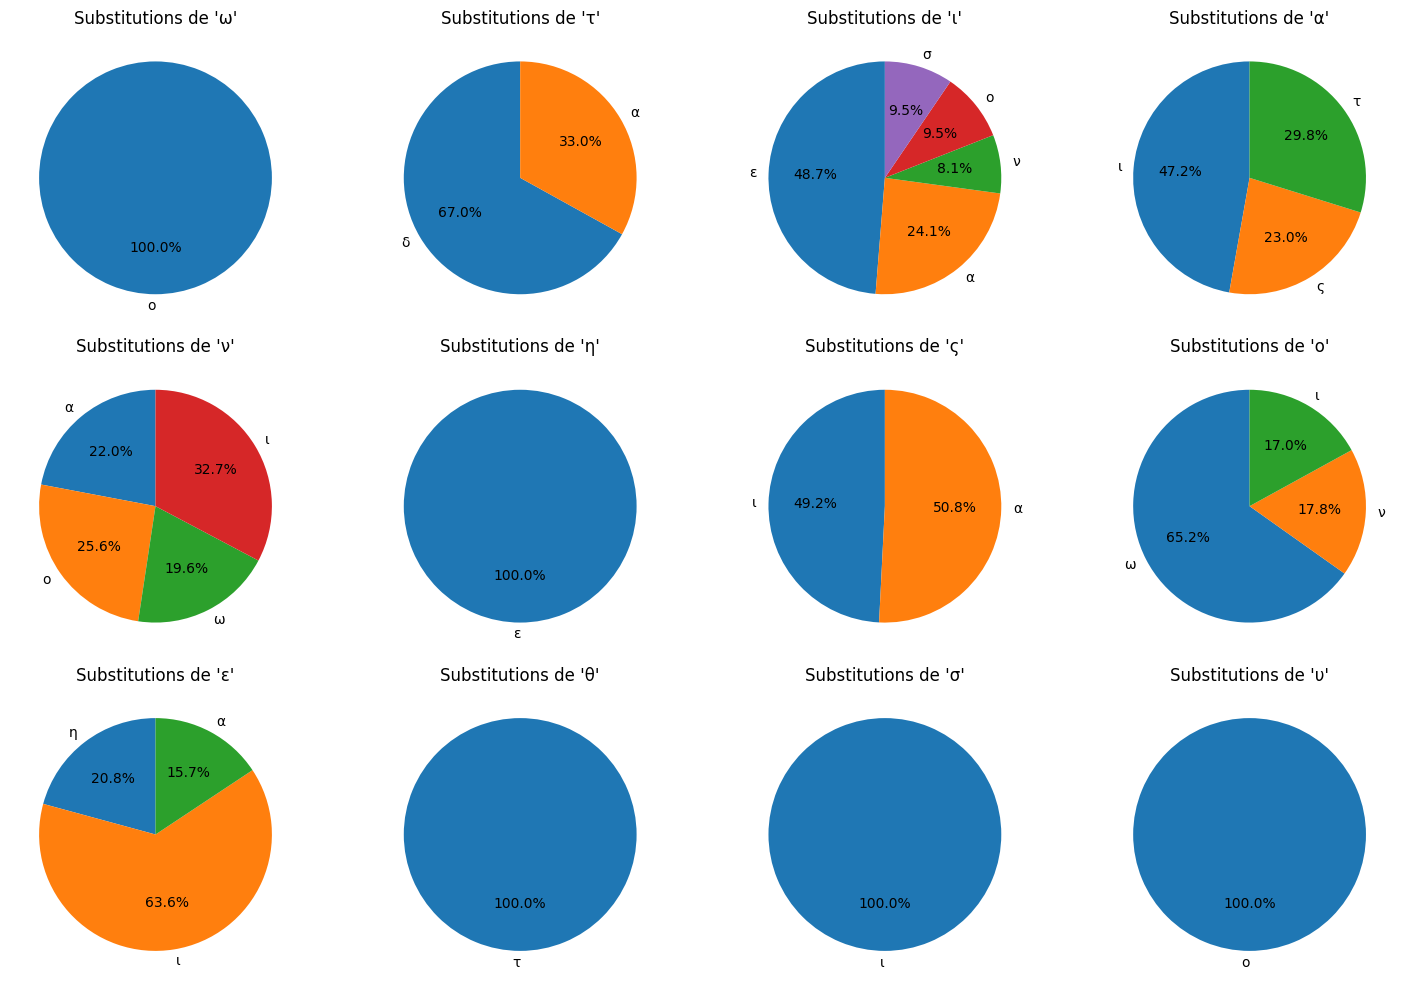

In [ ]:
# Créez un graphique unique qui représente pour chacun de ces 8 graphèmes la nouvelle forme qu'il va prendre sous la forme
# d'un pie chart (utilisez les subplots de matplotlib)

import matplotlib.pyplot as plt
from collections import defaultdict

# Organiser les données par graphème "old"
graphene_changes = defaultdict(lambda: defaultdict(int))

for (old, new), count in dico_couple_frequent.items():
    graphene_changes[old][new] += count

# Création des pie charts
fig, axes = plt.subplots(3, 4, figsize=(15, 10))  # 12 pie charts dans une grille 3x4
axes = axes.flatten()

# Pour chaque graphème "old", créer un pie chart
for i, (old, new_dict) in enumerate(graphene_changes.items()):
    labels = list(new_dict.keys())  # les graphèmes "new"
    sizes = list(new_dict.values())  # les comptages des substitutions

    # Calculer les proportions pour chaque substitution
    total = sum(sizes)
    proportions = [size / total for size in sizes]

    # Affichage du pie chart
    axes[i].pie(proportions, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"Substitutions de '{old}'")

plt.tight_layout()
plt.show()

# Transition

Quelles sont les colonnes du df ? Eliminez toutes celles qui vous paraissent inutiles et sauvez cela dans un fichier nommé "clean_papyrus-corpus.csv"
C'est ce fichier qui servira de base d'affichage du front de l'application que vous allez construire

In [ ]:
print(df.columns)

Index(['ID', 'Authors / works', 'Book form', 'Content (beta!)',
       'Culture & genre', 'Date', 'Full Text', 'Language/script', 'Material',
       'People List', 'Places List', 'Provenance', 'Recto/Verso',
       'Text Irregularities', 'Content_first_word', 'Provenance_first_word',
       'Reformatted_Date', 'First_Date', 'Uncertain Portion',
       'Full Text Cleaned', 'People List Cleaned', 'People Ugarit',
       'Places Ugarit', 'Other Ugarit', 'Irregularities Pairs'],
      dtype='object')


In [ ]:
# On supprime :
# - Content (beta!), étant donné qu'on a créé Content_first_word
# - Date, car on a plutôt Reformatted_Date
# - Culture & genre qui n'a que des NaN
# - Full Text, au profit de Full Text Cleaned
# - Provenance, au profit de Provenance_first_word
# - People List, au profit de People Ugarit
# - People List Cleaned, au profit de People Ugarit
# - Text Irregularities, au profit de Irregularities Pairs
# - Places List, au profit de Plcaes Uragat

In [ ]:
columns_to_drop = [
    'Content (beta!)',
    'Date', # 'First_Date',
    'Culture & genre',
    'Full Text',
    'Provenance',
    'People List',
    'People List Cleaned',
    'Text Irregularities',
    'Places List'
]

df = df.drop(columns=columns_to_drop)

In [ ]:
print(df.columns)

Index(['ID', 'Authors / works', 'Book form', 'Language/script', 'Material',
       'Recto/Verso', 'Content_first_word', 'Provenance_first_word',
       'Reformatted_Date', 'First_Date', 'Uncertain Portion',
       'Full Text Cleaned', 'People Ugarit', 'Places Ugarit', 'Other Ugarit',
       'Irregularities Pairs'],
      dtype='object')


In [ ]:
# remplacer les Nan par "Unknown" pour un meilleur affichage sur l'application streamlit
df = df.fillna('Unknown')

In [ ]:
df.to_csv('clean_papyrus-corpus.csv', index=False)

# III) Présenter le corpus /4

L'objectif de cette partie est de vous familiariser avec Streamlit https://streamlit.io/
Une librairie très intuitive pour construire en peu de lignes de codes une pseudo page web.

Lisez la documentation et les tutoriels  pour pouvoir suivre les consignes et construire l'application https://streamlit.io/components

L'ensemble de l'application doit être stockée dans un fichier unique nommé streamlit_papyrus.py et pouvoir tourner sans erreur au lancement de la commande
"streamlit run streamlit_papyrus.py"

# 9) Création de l'application présentant les papyrus

En utilisant les composants streamlit adaptés, créez:

* Sur la page principal, le titre de l'application ("La Chasse aux Papyrus"), une image de votre choix, ainsi qu'une description de l'application
* Dans la barre à gauche, créez un menu déroulant permettant de choisir un papyrus parmi tous ceux de la collection
* Si un papyrus est sélectionné, les informations principales le concernant sont affichées sur la page centrale
(numéro dans la collection en haut centré
, Date, Provenance, Personnes, Lieux et Textual Irregularities (utilisez le système de colones et composants pour les présenter sous la forme clé / valeur)
* Il y a vraiment beaucoup de papyri à choisir ! Pour simplifier la sélection, donnez l'option de mettre des filtres sur la provenance et  la date de découverte (selectbox pour le lieu, slider pour la date) dont la manipulation va limiter le nombre de papyrus potentiellement sélectionnable

In [ ]:
!pip install streamlit

In [ ]:
# III. Présenter le corpus
# 9. et 10.

import streamlit as st
import pandas as pd

df = pd.read_csv("clean_papyrus-corpus.csv")

# Titre, image et description
st.title("La Chasse aux Papyrus")
st.image("https://i.pinimg.com/736x/23/b9/a9/23b9a9af92ed0bded8a1bbdaf0becbcf.jpg", caption="Image générée à l'aide de Microsoft Copilot", width = 500)
st.write("""
    Bienvenue dans "La Chasse aux Papyrus" !
    Cette application vous permet de découvrir les papyrus de notre collection, avec des informations détaillées sur chaque pièce.
    Utilisez les filtres pour affiner votre recherche et explorer les papyrus par date de découverte et provenance.
""")

# Barre latérale pour les filtres
st.sidebar.title("Filtres")
provenance_filter = st.sidebar.selectbox(
    "Sélectionner la provenance",
    options=["Tous"] + df["Provenance_first_word"].unique().tolist()
)
date_filter = st.sidebar.slider(
    "Sélectionner la date de découverte",
    min_value=int(df["First_Date"].min()),
    max_value=int(df["First_Date"].max()),
    value=(int(df["First_Date"].min()), int(df["First_Date"].max()))
)

# Filtrage des données
filtered_df = df[
    (df["Provenance_first_word"] == provenance_filter if provenance_filter != "Tous" else True) &
    (df["First_Date"] >= date_filter[0]) &
    (df["First_Date"] <= date_filter[1])
]

# Menu déroulant pour la sélection du papyrus
selected_papyrus_id = st.selectbox(
    "Choisir un papyrus",
    options=filtered_df["ID"].tolist()
)

# Fonction pour afficher les papyrus associés à une personne ou un lieu
def display_associated_papyrus(search_column, search_value):
    associated_papyrus = df[df[search_column].str.contains(search_value, case=False, na=False)]
    if not associated_papyrus.empty:
        st.write(f"Papyrus où {search_value} apparaît :")
        st.dataframe(associated_papyrus[["ID", "Authors / works", "Reformatted_Date", "Provenance_first_word"]])
    else:
        st.write(f"Aucun papyrus trouvé pour {search_value}.")

# Affichage des informations du papyrus sélectionné
if selected_papyrus_id:
    selected_papyrus = filtered_df[filtered_df["ID"] == selected_papyrus_id].iloc[0]

    st.header(f"Papyrus ID: {selected_papyrus['ID']}")

    # Informations principales
    st.subheader("Informations principales")
    st.write(f"**Date de découverte**: {selected_papyrus['Reformatted_Date']}")
    st.write(f"**Provenance**: {selected_papyrus['Provenance_first_word']}")

    # Présentation des personnes et des lieux
    st.subheader("Personnes et Lieux")
    people = selected_papyrus['People Ugarit']
    places = selected_papyrus['Places Ugarit']

    # Afficher les noms de personnes et de lieux avec possibilité de filtrer
    people_list = people.split(", ") if people != "Unknown" else []
    places_list = places.split(", ") if places != "Unknown" else []

    # Affichage cliquable des personnes
    for person in people_list:
        person_display = st.button(f"Afficher les papyrus de {person}")
        if person_display:
            display_associated_papyrus("People Ugarit", person)

    # Affichage cliquable des lieux
    for place in places_list:
        place_display = st.button(f"Afficher les papyrus de {place}")
        if place_display:
            display_associated_papyrus("Places Ugarit", place)

    # Présentation des irrégularités textuelles sous forme d'annotation
    st.subheader("Irrégularités Textuelles")
    irregularities = selected_papyrus["Irregularities Pairs"]
    if irregularities and irregularities != "Unknown":
        st.write(f"**Irrégularités**: {irregularities}")

        # Annotation du texte avec les irrégularités
        full_text = selected_papyrus["Full Text Cleaned"]
        for irr in eval(irregularities):  # Le format est une liste de tuples
            original, corrected = irr
            full_text = full_text.replace(original, f"**{original}** → *{corrected}*")

        st.text_area("Texte avec annotations", full_text, height=300)
    else:
        st.write("Aucune irrégularité textuelle identifiée.")

    # Option de visualisation du texte complet nettoyé
    if st.checkbox("Afficher le texte complet nettoyé"):
        st.text(selected_papyrus["Full Text Cleaned"])

# Fonctionnalité supplémentaire : Recherche de mot dans les papyrus
st.sidebar.title("Recherche de mot dans les papyrus")
search_word = st.sidebar.text_input("Entrez un mot à rechercher")
if search_word:
    search_results = df[df['Full Text Cleaned'].str.contains(search_word, case=False, na=False)]
    if not search_results.empty:
        st.write(f"Papyrus contenant le mot '{search_word}':")
        st.dataframe(search_results[["ID", "Authors / works", "Reformatted_Date", "Provenance_first_word"]])
    else:
        st.write(f"Aucun papyrus ne contient le mot '{search_word}'.")


# Ma fonctionnalité supplémentaire : rechercher un mot dans les papyrus, et afficher tous les papyrus qui contiennent ce mot.
# Permet de trouver rapidement tous les papyrus qui contiennent un terme particulier,
# utile pour les recherches ciblées ou pour étudier des mots-clés spécifiques dans les textes anciens.

# 10) enrichissement des données

Le but est d'approfondir sa connaissance de streamlit
* Faites en sorte que quand on clique sur un nom de lieu ou de personne on fasse apparaître la liste des papyri dans lesquels il apparaît
* Faites apparaître les corrections de la colonne Text Irregularities dans le texte sous forme d'annotation textuelle streamlit

*Ajoutez une fonctionnalité supplémentaire à l'application.
* Expliquez son intêrét et comment vous l'avez codé




In [ ]:
# pris en compte dans le code ci-dessus (9.)

# BONUS HARDCORE (/2 points) :

Affichez les lieux mentionnés dans les papyri sur une carte